# Generate Skew Factor Heat Maps

A constraint of any traffic matrix is that the load on each end point (the fraction of the end point's capacity being requested) cannot exceed 1.0. Consequently, certain traffic skews become infeasible at higher loads (for example, it is impossible for an $n>1$ network to have 1 node requesting 100\% of the traffic if the overall network is under a 1.0 load). This results in all traffic matrices tending towards uniform (i.e. having no skew) as the overall network load tends to 1.0. 

A question traffic trace generators may ask is: for a given load, what combination of (1) number of skewed nodes, (2) corresponding fraction of the arriving network traffic the skewed nodes request, and (3) overall network load results in the traffic matrix being skewed or not skewed? To answer this question, we make the following assumptions:

- All network end points have equal bandwidth capacities.
- All end points are either 'skewed' or 'not skewed' by the same amount.
- 'Skew' is defined by a \textit{skew factor}, which is the fractional difference between the load rate per skewed node and the load rate per non-skewed node (the highest being the numerator, and the lowest being the denominator).
- For a given combination of skewed nodes and the load rate they request of some overall network load, any excess load (exceeding 1.0) on a given end point is distributed equally amongst all other end points whose loads are $<1.0$.

With the above assumptions, we can calculate the skew factor for each combination of skewed nodes, corresponding traffic requested, and overall network load. Doing this for 0-100\% of the network nodes being skewed and requesting 0-100\% of the overall network load under network loads 0.1-0.9, we can construct a look-up table of skew factors for each of these combinations before generating any actual traffic. 


To do this, we can use the `trafpy.generator.gen_network_skewness_heat_maps()` function. Use e.g. `num_eps=100` and `plot_labeled_heat_map=False` if you want to plot grids (low resolution), or e.g. `num_eps=1000` and `plot_labeled_heat_map=True` if you want to plot heat maps (high resolution).

Unlabelled heat map (high resolution):

/home/cwfparsonson/Insync/zciccwf@ucl.ac.uk/OneDriveBiz/ipes_cdt/phd_project/projects/trafpy/trafpy/generator/src/flowcentric.py:1073: RuntimeWarning: invalid value encountered in double_scalars
  traffic_per_skewed_node = (traffic_all_skewed_nodes / num_skewed) * load
/home/cwfparsonson/Insync/zciccwf@ucl.ac.uk/OneDriveBiz/ipes_cdt/phd_project/projects/trafpy/trafpy/generator/src/flowcentric.py:1073: RuntimeWarning: divide by zero encountered in double_scalars
  traffic_per_skewed_node = (traffic_all_skewed_nodes / num_skewed) * load
/home/cwfparsonson/Insync/zciccwf@ucl.ac.uk/OneDriveBiz/ipes_cdt/phd_project/projects/trafpy/trafpy/generator/src/flowcentric.py:1083: RuntimeWarning: invalid value encountered in double_scalars
  total_excess = excess_per_node * num_skewed
/home/cwfparsonson/Insync/zciccwf@ucl.ac.uk/OneDriveBiz/ipes_cdt/phd_project/projects/trafpy/trafpy/generator/src/flowcentric.py:1107: RuntimeWarning: divide by zero encountered in double_scalars
  skew = max([traffic_

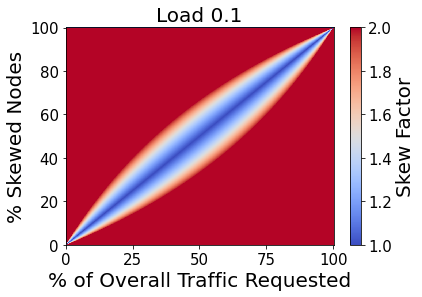

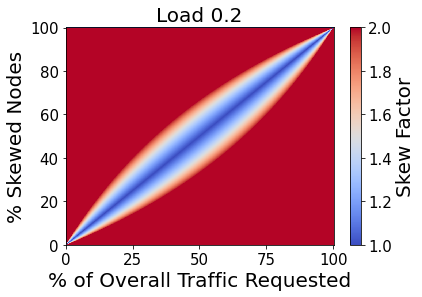

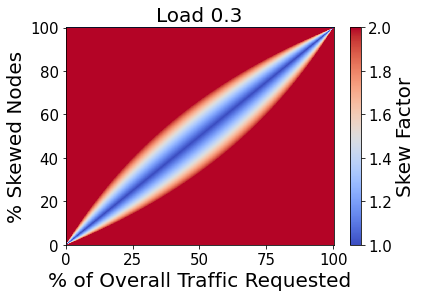

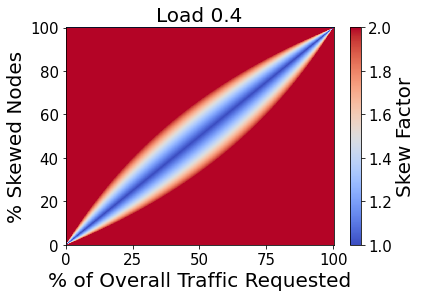

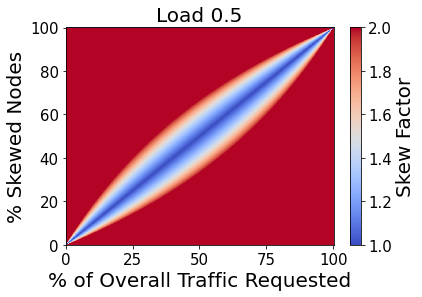

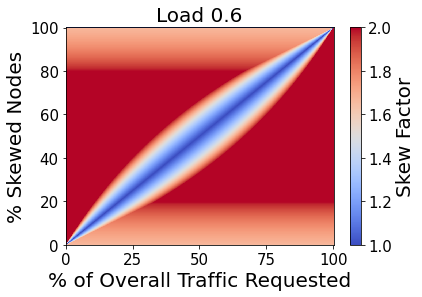

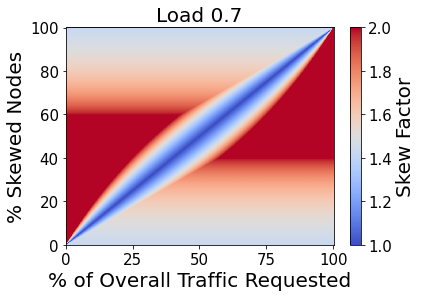

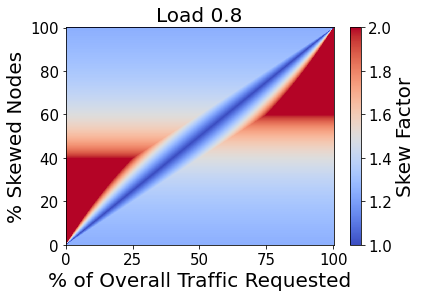

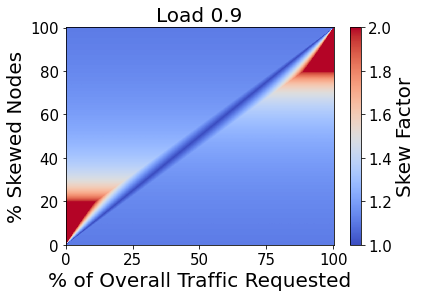

In [1]:
import trafpy.generator as tpg

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# get skewness heat map
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=1000)
skewed_nodes_traffic_requested, proportion_nodes_skewed, heat_maps, figs = tpg.gen_network_skewness_heat_maps(net, 
                                                                                                              show_fig=True,
                                                                                                              plot_labeled_heat_map=False,
                                                                                                              font_size=20,
                                                                                                              figsize=(6,4),
                                                                                                              labeled_grid_resolution=0.05,
                                                                                                              path_to_save=None,
                                                                                                              print_data=False)

The unlabelled coloured heat map shows a high resolution (0.1%) heat map of these combinations, with any skew factors $\geq2.0$ set to the same colour for visual clarity. 

Labelled heat map grids (low resolution):

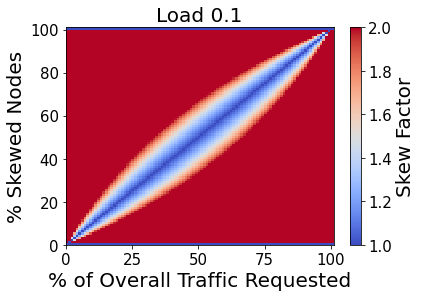

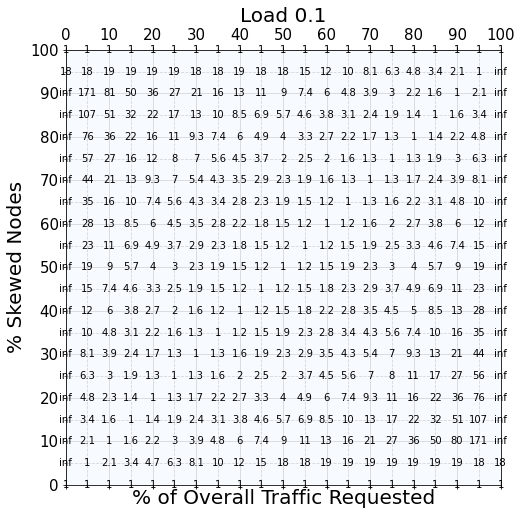

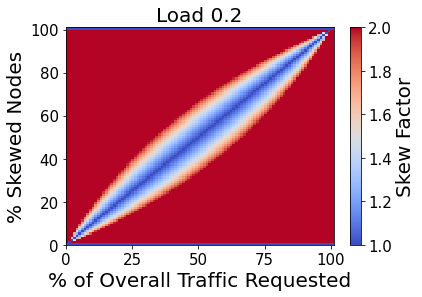

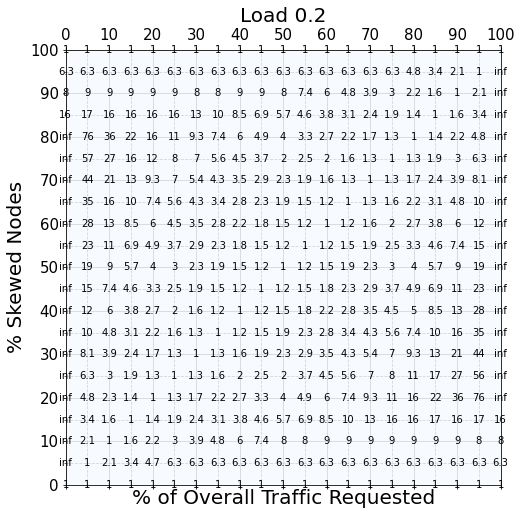

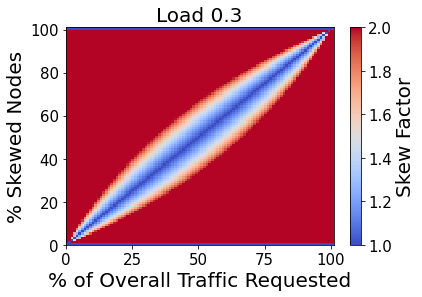

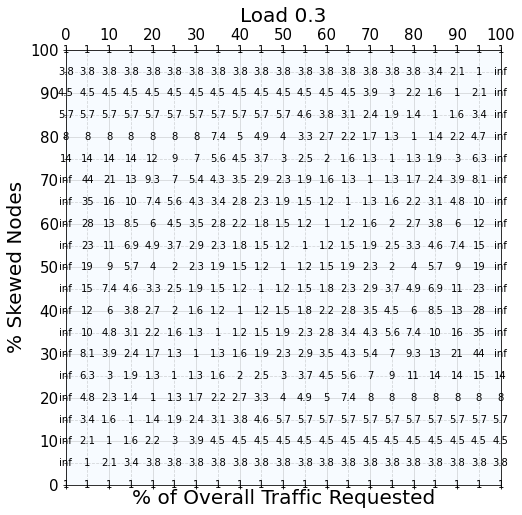

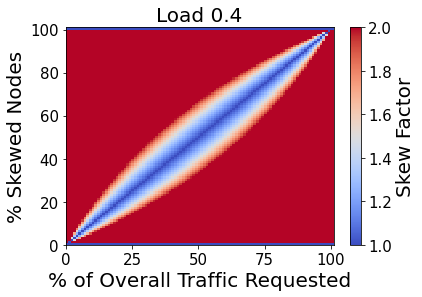

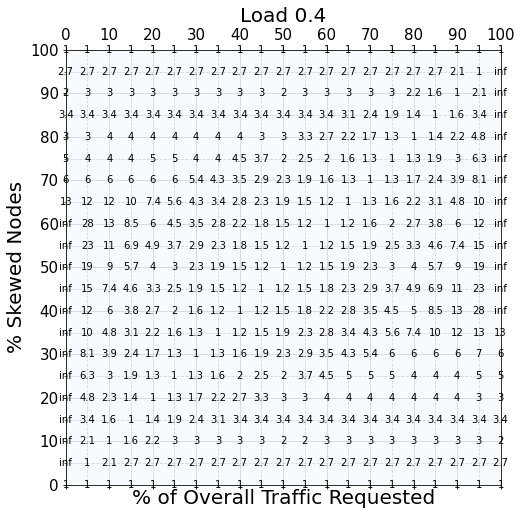

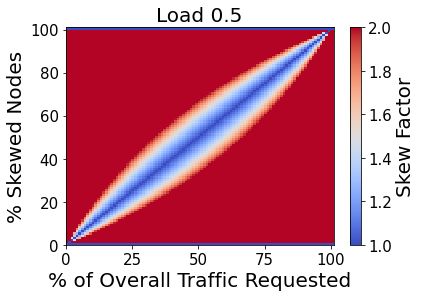

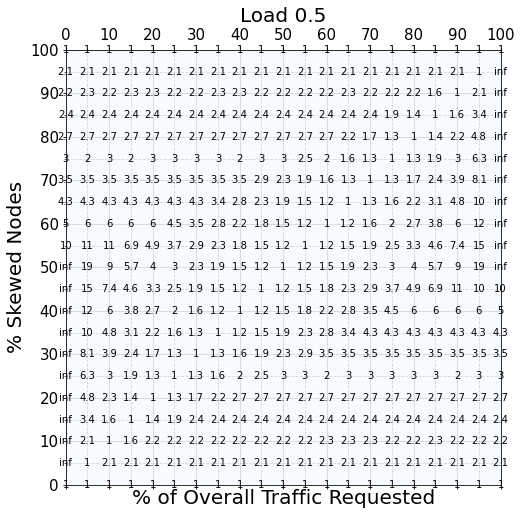

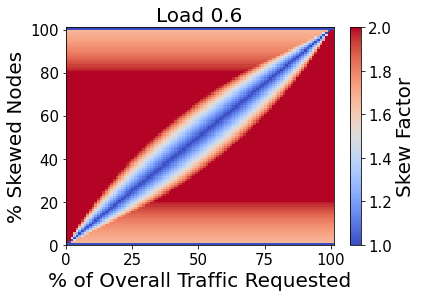

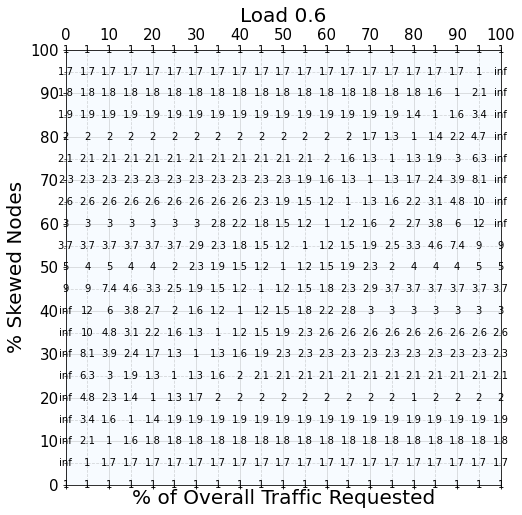

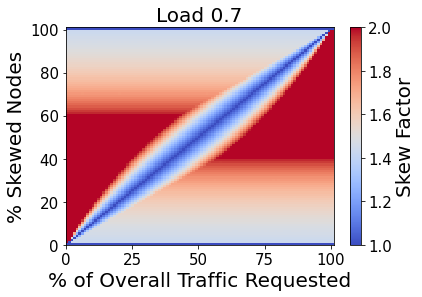

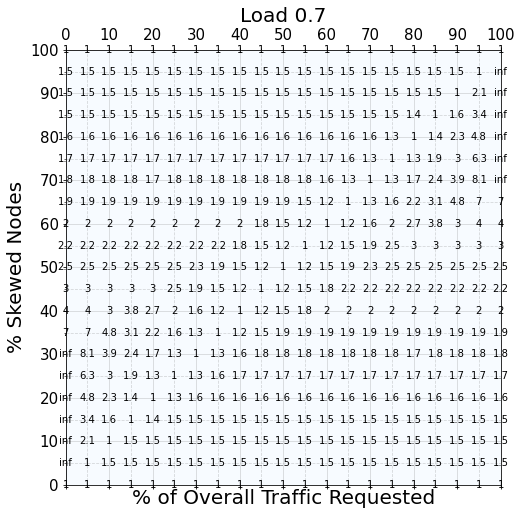

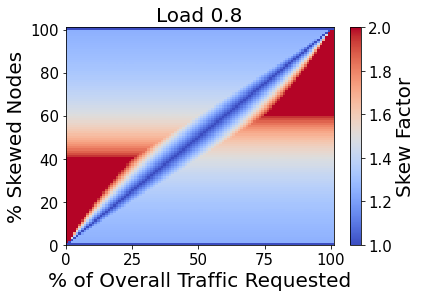

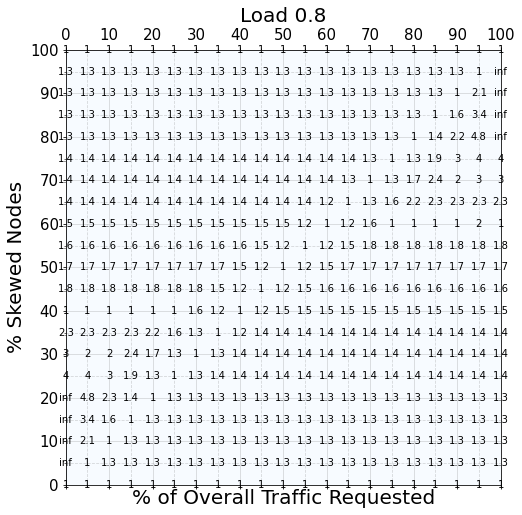

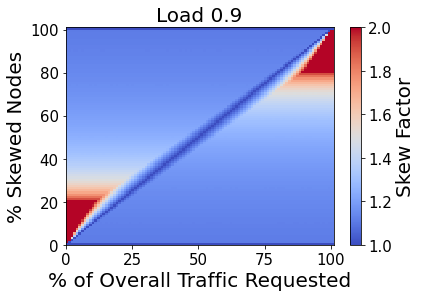

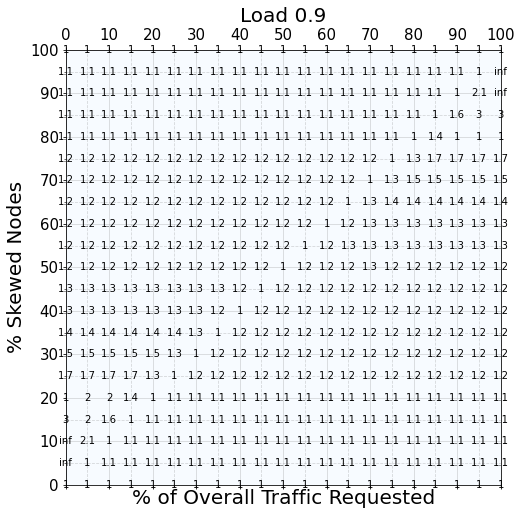

In [2]:
# get skewness heat map
net = tpg.gen_arbitrary_network(ep_label=None, num_eps=100)
skewed_nodes_traffic_requested, proportion_nodes_skewed, heat_maps, figs = tpg.gen_network_skewness_heat_maps(net, 
                                                                                                              show_fig=True,
                                                                                                              plot_labeled_heat_map=True,
                                                                                                              font_size=20,
                                                                                                              figsize=(6,4),
                                                                                                              labeled_grid_resolution=0.05,
                                                                                                              path_to_save=None,
                                                                                                              print_data=False)

The labelled grid shows the heat maps' corresponding plots with lower resolution (5\%) but with the skew factors labelled. As expected, above 0.6 network loads, certain combinations of number of skewed nodes and traffic requested become restricted as to how much skew there can be in the matrix, with many combinations tending towards uniform (skew factor 1.0) at 0.9 loads.


Using the skew factor data from the grids, we can be confident at 5%, 10%, 20%, and 40% of the network nodes requesting 55% of the overall network traffic that the skew factor will be $>1.0$ across loads 0.1-0.9. The below figure shows the skew factor as a function of load for these combinations. Therefore, these were the combinations chosen for the skewed nodes sensitivity benchmark defined in the seminal `TrafPy` paper.

<Figure size 432x288 with 0 Axes>

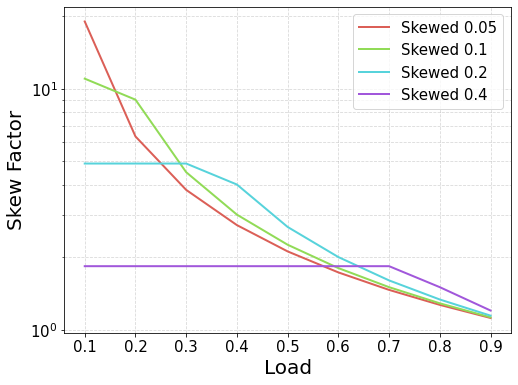

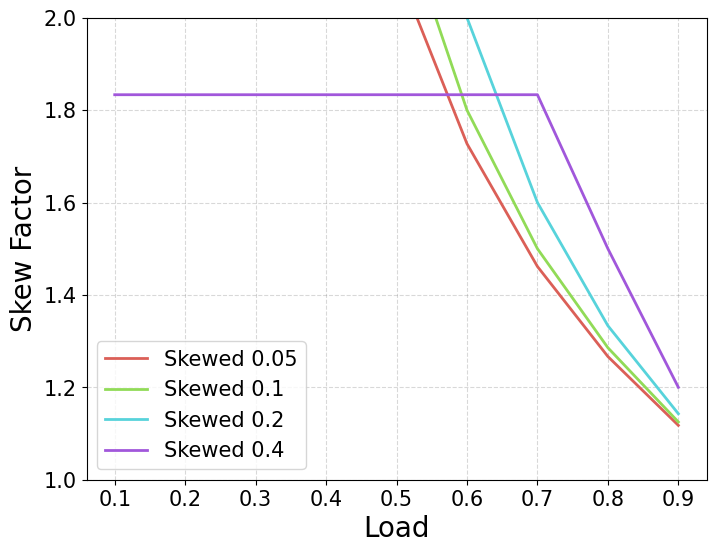

In [3]:
# use labelled heat map grid to plot skew vs loda etc

from collections import defaultdict

# plot skew vs. load for various % skewed nodes
# collect data
skew_ii, skew_iii, skew_iv, skew_v = [], [], [], []
skews = {0.05: [], 0.1: [], 0.2: [], 0.4: []}
loads = list(heat_maps.keys())
fig = plt.figure()
for load in loads:
    for num_skew_nodes in skews.keys():
        # find matrix row and col indices closest to these values
        row_idx = tpg.get_val_idx_in_matrix(heat_maps[load], axis='y', val=num_skew_nodes, axis_vals=proportion_nodes_skewed)
        col_idx = tpg.get_val_idx_in_matrix(heat_maps[load], axis='x', val=0.55, axis_vals=skewed_nodes_traffic_requested)
        skews[num_skew_nodes].append(heat_maps[load][row_idx, col_idx])

# plot data
nested_dict = lambda: defaultdict(nested_dict)
plot_dict = nested_dict()
for skew in skews:
    plot_dict['Skewed {}'.format(skew)]['x_values'] = loads
    plot_dict['Skewed {}'.format(skew)]['y_values'] = skews[skew]

# plot full range skew factor w/ logscale y-axis
fig = tpg.plot_val_line(plot_dict,
                      xlabel='Load',
                      ylabel='Skew Factor',
                      show_fig=True,
                      linewidth=2,
                      ylogscale=True,
                      figsize=(8,6),
                      font_size=20)

# plot limited range skew factor w/o logscale y-axis
fig = tpg.plot_val_line(plot_dict,
                      xlabel='Load',
                      ylabel='Skew Factor',
                      show_fig=True,
                      ylim=[1,2],
                      linewidth=2,
                      figsize=(8,6),
                      font_size=20)